In [1]:
import os
from pathlib import Path
from src.visualization.visualize import visualize_sample
from src.data.dataset import KittiDataset

processed_path = str(Path(os.path.abspath('')).resolve().parents[0] / "data" / "processed")

training_dataset = KittiDataset(root_dir=processed_path, load_raw=False)
validation_dataset = KittiDataset(root_dir=processed_path, train=False, load_raw=False)

In [2]:
print(f"Training data - {len(training_dataset)}")
print(f"Validation data - {len(validation_dataset)}")

Training data - 85898
Validation data - 6852


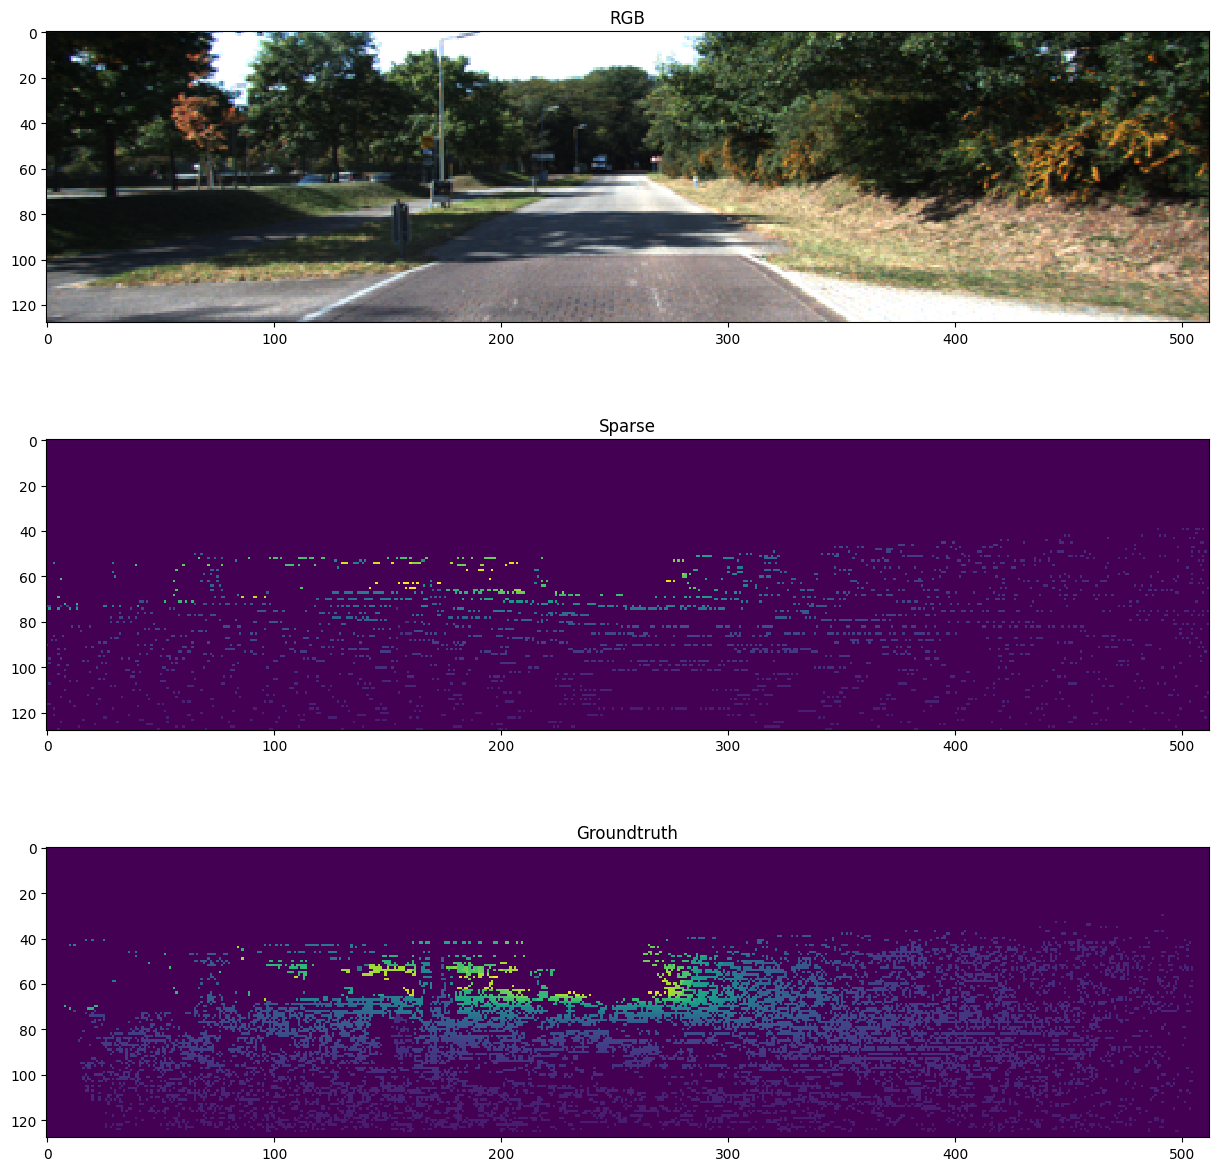

In [3]:
visualize_sample(training_dataset[1000])

### LiDAR downsampling

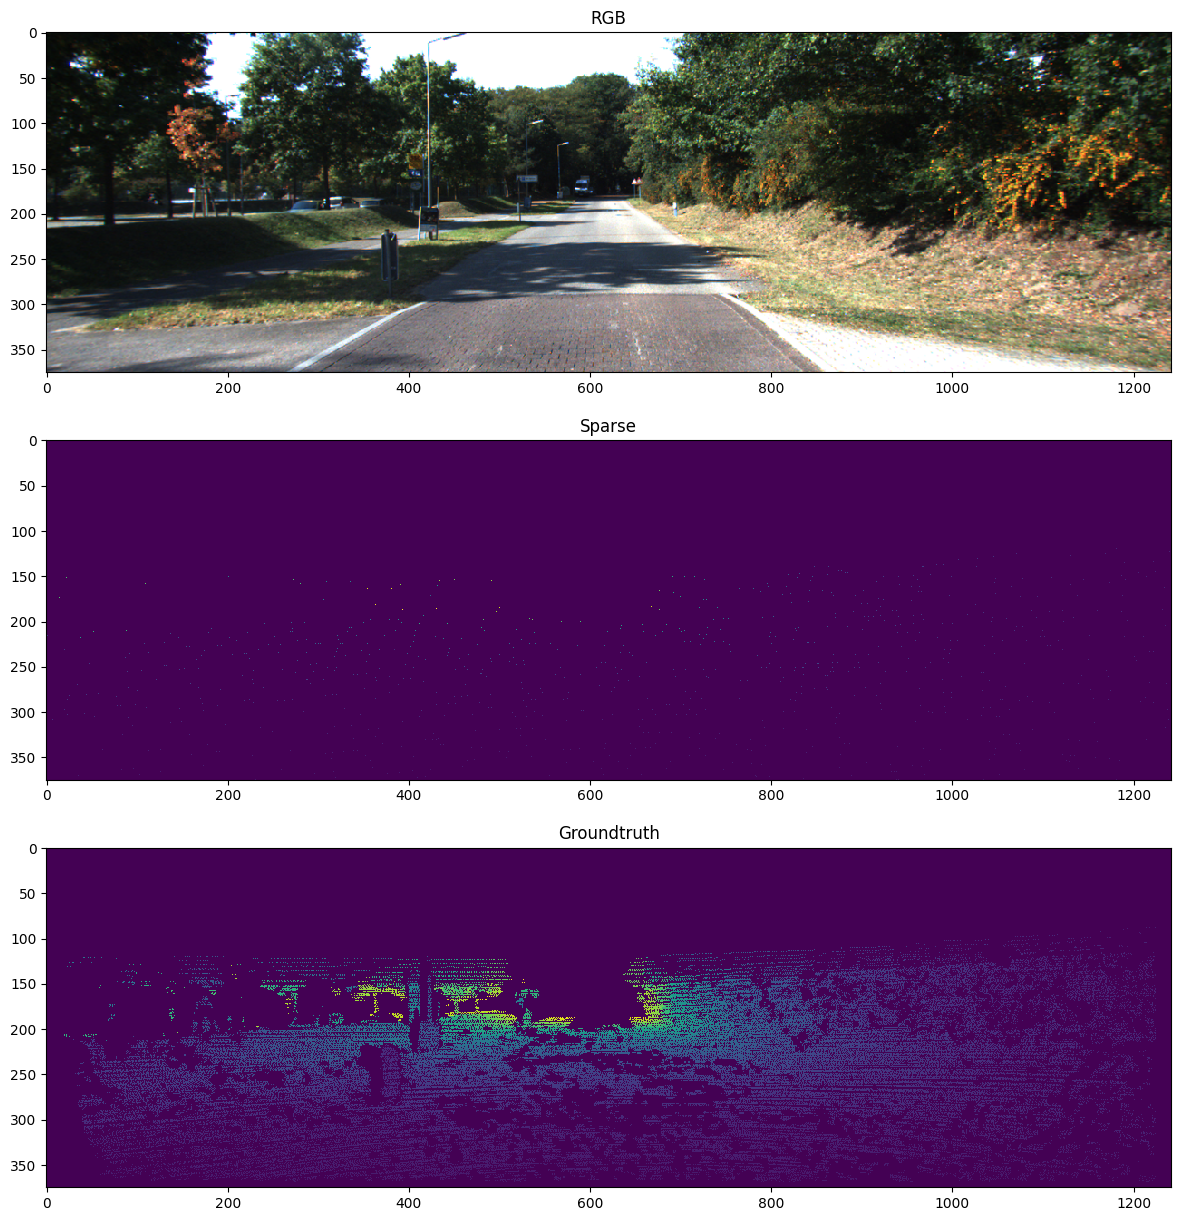

In [4]:
training_dataset_downsample = KittiDataset(downsample_lidar=True)
visualize_sample(training_dataset_downsample[1000])

In [5]:
from src.models.model import uncertainty_net
import torch
from torch.utils.data import DataLoader

model_path = "../models/model_best_epoch.pth.tar"
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

model = uncertainty_net(4)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

lowest_loss = checkpoint['loss']
best_epoch = checkpoint['best epoch']
print('Lowest RMSE for selection validation set was {:.4f} in epoch {}'.format(lowest_loss, best_epoch))

validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False, pin_memory=True, drop_last=True)

Lowest RMSE for selection validation set was 0.7908 in epoch 59


In [6]:
predictions = []
for i, sample in enumerate(validation_loader):
    if i < 10:
        (rgb, sparse, gt) = sample
        input = torch.cat((sparse, rgb), 1)
        _, _, output, _ = model(input)
        output = torch.clamp(output, min=0, max=85)
        output = output[0][0:1].cpu().detach().numpy()
        predictions.append((
            (rgb.numpy().squeeze(0), sparse.numpy().squeeze(0), gt.numpy().squeeze(0)),
            output
        ))
    else:
        break

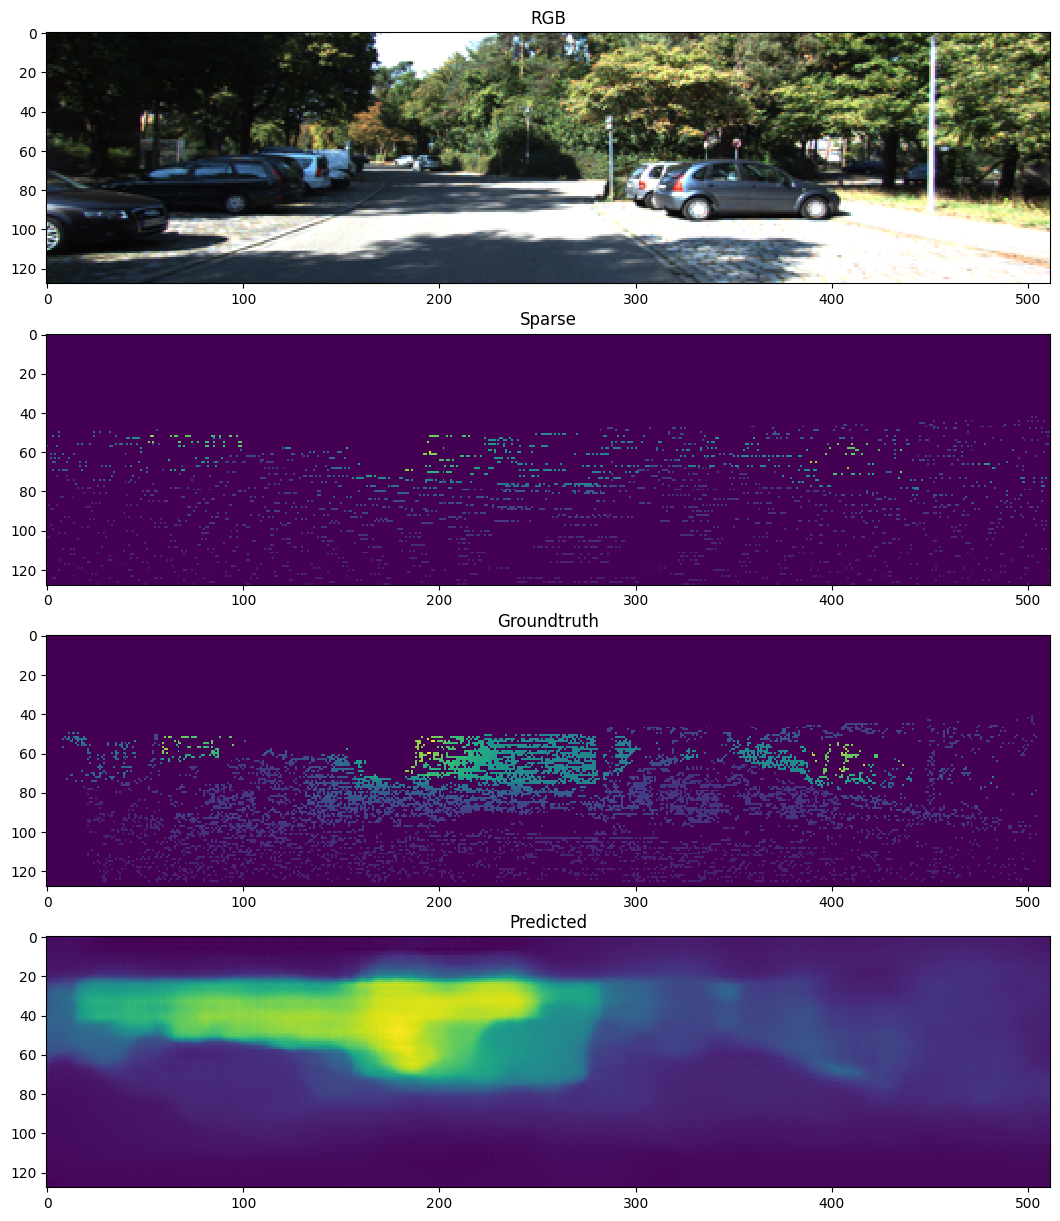

In [7]:
visualize_sample(sample=predictions[0][0], prediction=predictions[0][1])

In [8]:
from src.models.training.train_model import train_model
from src.models.training.config import TrainingConfig


config = TrainingConfig(
    output_path=str(Path(os.path.abspath('')).resolve().parents[0] / "models" / "trainings"),
    epochs=50,
    batch_size=32,
    dataset_path=processed_path,
    learning_rate=1e-3
)

train_model(config)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/devolay/depth-completion/e/DEP-2



  | Name  | Type            | Params
------------------------------------------
0 | model | uncertainty_net | 2.5 M 
------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.181    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/dawid/anaconda3/envs/depth-completion-mp/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/dawid/Private/School/Sem 1/Machine Perception/Project/depth-completion-mp/src/models/lightning_wrapper.py:25: Using a target size (torch.Size([32, 1, 128, 512])) that is different to the input size (torch.Size([32, 2, 128, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


/Users/dawid/anaconda3/envs/depth-completion-mp/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0:   2%|▏         | 66/2684 [01:44<1:09:09,  0.63it/s, v_num=EP-2]